# Jitter amplification in our X-band linac from 100 to 500 MeV

In [1]:
%plot -f SVG

In [2]:
RF_Track;


RF-Track, version 2.3.3a0

Copyright (C) 2016-2025 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track

RF-Track was compiled with GSL-2.7 and fftw-3.3.10



## Load the field map from a file
This field map is inspired by the structure presented in this paper: 

W. L. Millar et al., "High-Power Test of Two Prototype X-Band Accelerating Structures Based on SwissFEL Fabrication Technology," in IEEE Transactions on Nuclear Science, vol. 70, no. 1, pp. 1-19, Jan. 2023, doi: 10.1109/TNS.2022.3230567. https://ieeexplore.ieee.org/document/9991980

In [3]:
T = load('data/TWS_Xband.dat');

## Prepare for the RF-Track element

In [4]:
Ez = T(:,2) + 1j * T(:,3); % MV/m
hz = T(2,1) - T(1,1); % m

Let's plot it to see what it looks like

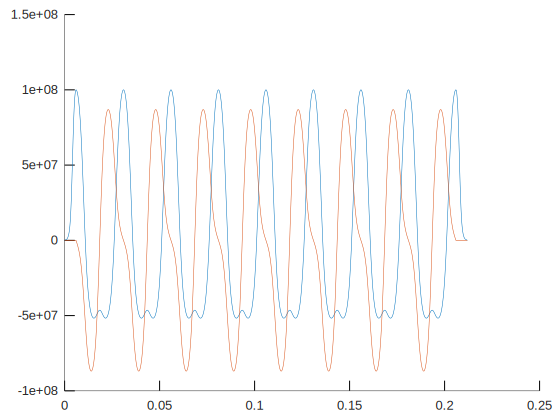

In [5]:
hold on
plot(T(:,1), real(Ez))
plot(T(:,1), imag(Ez))

G_map = mean(abs(Ez)); % V/m

## Create a new element
The field map was computed assuming 37.5 MW input power to provide a 100 MV/m peak field. We want to operate this structure at an 80 MV/m peak field. In a TW structure, the power and the gradient are related by the following expression: $$G = \sqrt{\frac{\omega r/Q P}{v_g}}.$$ 

Assuming a linear relationship between the gradient $G$ and the max $E_z$ field, the required input power must be reduced according to the following expression:
$$
P_\text{actual} = P_\text{map}\left( {\frac{E_\text{z max, actual}}{E_\text{z max, map}}} \right)^2.
$$

Like in the previous example, we create a new element of type RF_FieldMap_1D, but, this time, we add two new arguments to the constructor, $ P_\text{map}$ and $P_\text{actual}$ to specify our operating input power.

In [6]:
freq = 11.9942e9; % Hz
phid = 0; % degrees

E_map = 100e6; % V/m, the max Ez field of the field map
E_actual = 80e6; % V/m, our max Ez field 

P_map = 37.5e6; % W, the field map was generated assuming 37.5 MW input power, to provide 100 MV/m gradient
P_actual = P_map * E_actual^2/E_map^2; % W, we want to operate at 80 MV/m

RF = RF_FieldMap_1d (Ez, hz, -1, freq, +1, P_map, P_actual);
RF.set_phid (phid);
RF.set_nsteps (1000);

Let's plot the field using ```get_field()```

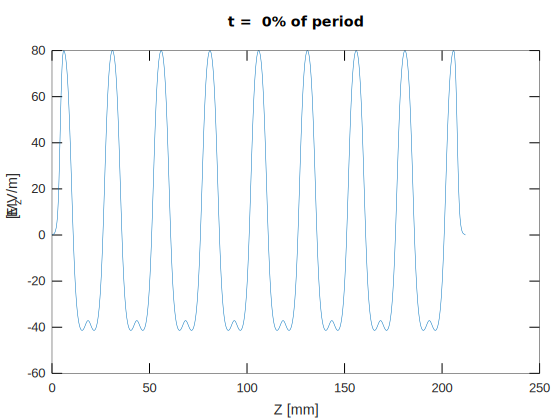

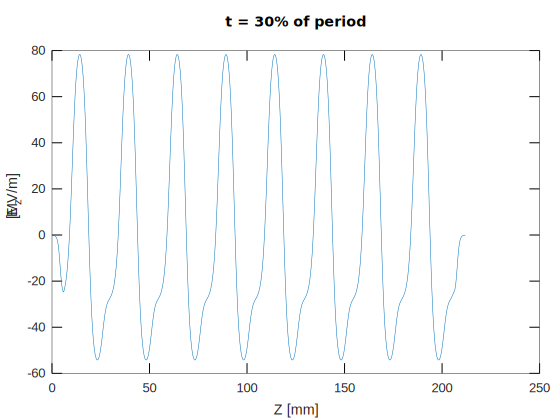

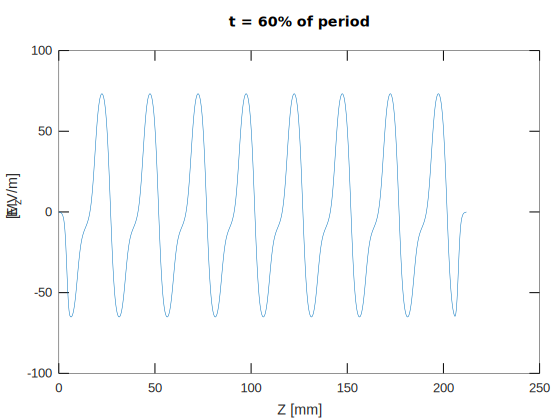

In [7]:
RF.set_t0(0.0); % for plotting
T_period = RF.get_period(); % mm/c

Z = linspace(0, RF.get_length()*1e3, 1000); % mm
O = zeros(size(Z));
I = ones(size(Z));

for t = [ 0.0 0.3 0.6 ]*T_period

    % read the field
    [E,B] = RF.get_field (O, O, Z, t*I);
    figure;
    plot (Z, E(:,3) / 1e6);
    title (sprintf('t = %2.f%% of period', t*100/T_period));
    xlabel ('Z [mm]');
    ylabel ('E_z [MV/m]');
    
end

RF.unset_t0();

In [8]:
L_RF = RF.get_length()

L_RF = 0.2120


## Let's define some beam parameters

In [9]:
%% Bunch parameters
mass = RF_Track.electronmass; % MeV/c^2
Q = -1; % single-particle charge, in units of e
population = 50 * RF_Track.pC; % number of real particles per bunch

P_i = 100; % initial momentum, MeV/c
P_f = 500; % final momentum, MeV/c

## Let's build the linac lattice
We use a standard FODO lattice, with four structures every two consecutive quadrupoles and 90 degrees phase advance per cell

In [10]:
%% FODO cell parameters
Lquad = 0.1; % m
Lcell = 8*L_RF + 2*Lquad; % m, eight structures and two quadrupoles

In [11]:
mu = 90; % deg
k1L = sind(mu/2) / (Lcell/4); % 1/m, integrateg focusing strength

### The unit FODO cell
Each FODO cell can be considered as an RF module.
Initially, we leave the quadrupoles off; their strength is 0.0.

In [12]:
FODO = Lattice();
FODO.append ( RF );
FODO.append ( RF );
FODO.append ( RF );
FODO.append ( RF );
FODO.append ( Quadrupole (Lquad, 0.0 ));
FODO.append ( RF );
FODO.append ( RF );
FODO.append ( RF );
FODO.append ( RF );
FODO.append ( Quadrupole (Lquad, 0.0 ));

We need to find what is the maximum energy gain per cell, so we define a reference particle and track it through the cell

In [13]:
% Define the reference particle
P0 = Bunch6d (mass, population, Q, [ 0 0 0 0 0 P_i ]);

% We use autophase to set the phases and to determine P_final, the maximum final momentum
P_final = FODO.autophase (P0); % MeV/c

% The momentum gain is
P_gain = P_final - P_i   % MeV/c

P_gain = 98.375


Let's compute how many FODO cells we need

In [14]:
n_FODO = (P_f - P_i) / P_gain

n_FODO = 4.0661


In [15]:
n_FODO = round(n_FODO)    % let's round it to the nearest integer

n_FODO = 4


As we intend to use several instances of the same FODO cell, we need to unset the reference time from FODO so that we can put four cells in a lattice and have each have its own reference time.

In [16]:
FODO.unset_t0()

% Start a new lattice
LINAC = Lattice();

% 1/2 quad, let's start with half a quad
LINAC.append ( Quadrupole (Lquad/2, 0.0) );

% let's put out n_FODO cells
for i=1:n_FODO
    LINAC.append (FODO);
end

In [17]:
LINAC.get_length()

ans = 7.6327


## Let's track the reference particle and do some plots

In [18]:
% Track the reference particle
P1 = LINAC.track(P0);

Plot the energy profile along the linac

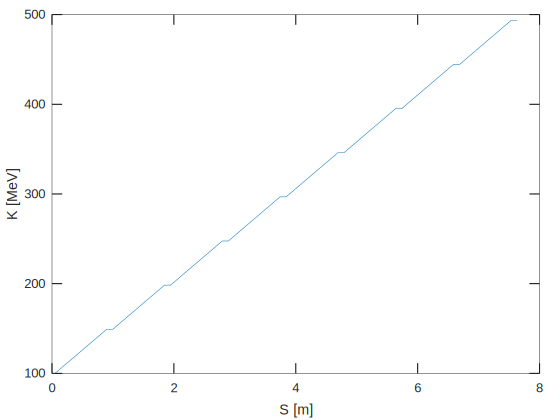

In [19]:
% Extract the "transport table"
T = LINAC.get_transport_table('%S %mean_P');

plot (T(:,1), T(:,2))
xlabel ('S [m]')
ylabel ('K [MeV]')

Now, we need to set the quadrupole strengths. We can use ```set_K1```, which accepts two parameters:
* the reference rigidity, $P/q$
* the quadrupole's focusing strength, in 1/m$^2$

In [20]:
Quads = LINAC.get_quadrupoles();

In [21]:
length(Quads)

ans = 9


It is convenient to use the normalised focusing strength, $k_1$

In [22]:
k1 = k1L / Lquad; % 1/m^2

In [23]:
half_P_gain = 0.5 * P_gain;

P = P_i; % initial momentum
for q = Quads

  % set quadrupole strength
  q{1}.set_K1 (P/Q, k1);
 
  % update the momentum variable
  P += half_P_gain;         % 

  % changes the sign of k1, anticipating the next quadrupole
  k1 = -k1;
 
end

## Define a bunch

In [24]:
%% Define Twiss parameters
Twiss = Bunch6d_twiss();
Twiss.emitt_x = 5; % mm.mrad, normalized emittances
Twiss.emitt_y = 5; % mm.mrad
Twiss.beta_x = Lcell * (1 - sind(mu/2)) / sind(mu); % m
Twiss.beta_y = Lcell * (1 + sind(mu/2)) / sind(mu); % m

%% Create the bunch
B0 = Bunch6d_QR (mass, population, Q, P_i, Twiss, 1000);

## Perform tracking

In [25]:
B1 = LINAC.track(B0);

Let's make some plots...

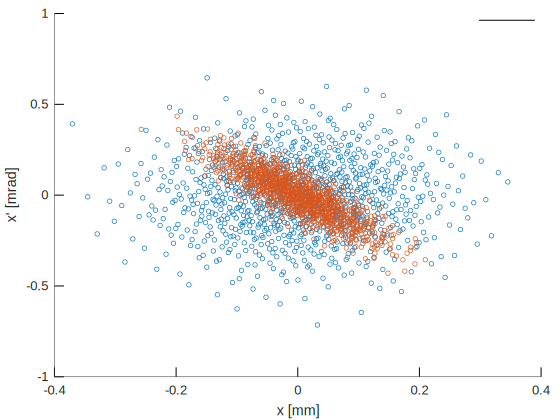

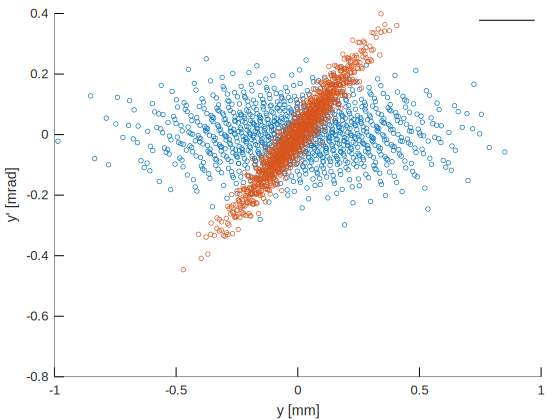

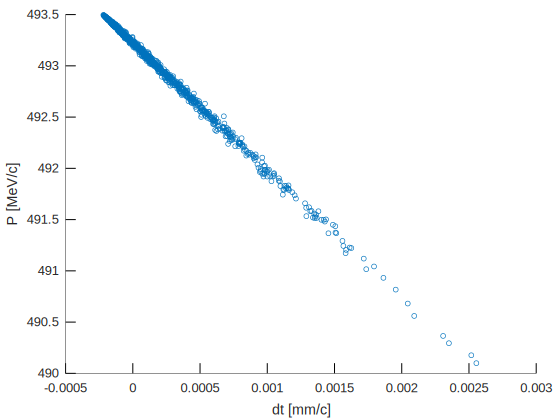

In [26]:
M0 = B0.get_phase_space ('%x %xp %y %yp %dt %P');
M1 = B1.get_phase_space ('%x %xp %y %yp %dt %P');

figure
hold on
scatter(M0(:,1), M0(:,2))
scatter(M1(:,1), M1(:,2))
legend({'initial', 'final'});
xlabel('x [mm]');
ylabel('x'' [mrad]');

figure
hold on
scatter(M0(:,3), M0(:,4))
scatter(M1(:,3), M1(:,4))
legend({'initial', 'final'});
xlabel('y [mm]');
ylabel('y'' [mrad]');

figure
scatter(M1(:,5), M1(:,6))
xlabel('dt [mm/c]');
ylabel('P [MeV/c]');

In [27]:
T = LINAC.get_transport_table('%S %mean_x %mean_y');

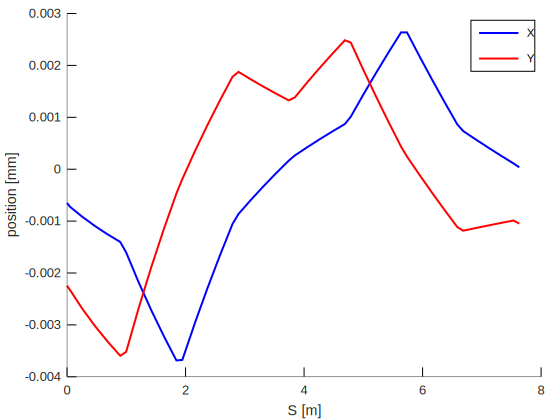

In [28]:
hold on
plot(T(:,1), T(:,2), 'b-', 'linewidth', 2);
plot(T(:,1), T(:,3), 'r-', 'linewidth', 2);
legend('X', 'Y');
xlabel('S [m]');
ylabel('position [mm]');

In [29]:
T = LINAC.get_transport_table('%S %emitt_x %emitt_y');

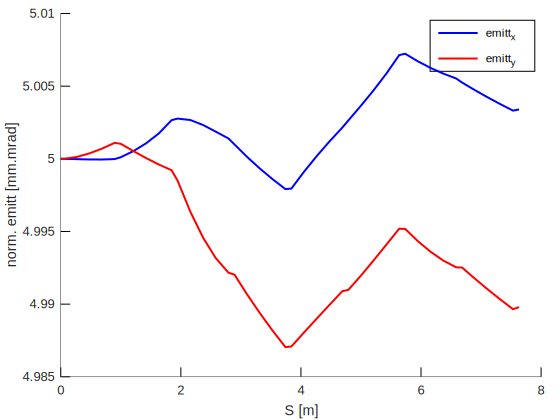

In [30]:
hold on
plot(T(:,1), T(:,2), 'b-', 'linewidth', 2);
plot(T(:,1), T(:,3), 'r-', 'linewidth', 2);
legend('emitt_x', 'emitt_y');
xlabel('S [m]');
ylabel('norm. emitt [mm.mrad]');

In [31]:
%RF = Drift( RF.get_length());
%RF.set_static_Efield(0, 0, -E_actual);

## Jitter amplification study
We paint an ellipse in the input phase space to evaluate the action amplification (jitter amplification)

In [32]:
N = 13;
Angles = linspace(0, 360, N)(1:N-1)

Angles =

     0    30    60    90   120   150   180   210   240   270   300   330



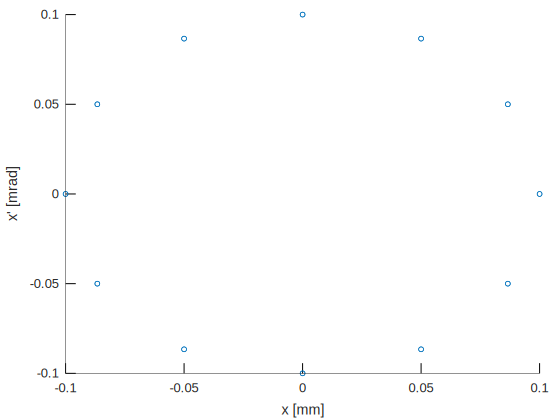

In [33]:
T = [];

sigma_X = 1;
sigma_Xp = 1;

for angle = Angles
    
    x =  0.1 * cosd(angle) * sigma_X; % mm, add an offset in X
    xp = 0.1 * sind(angle) * sigma_Xp; % mrad, add an offset in X'

    T = [ T ; x xp ];

end

scatter(T(:,1), T(:,2))
xlabel('x [mm]')
ylabel('x'' [mrad]')


In [34]:
B0 = Bunch6d_QR (mass, population, Q, P_i, Twiss, 1000);
M0 = B0.get_phase_space();

sigma_X  = std(M0(:,1)); % mm
sigma_Xp = std(M0(:,2)); % mrad

T_X = [];
T_Px = [];
for angle = Angles

    disp([ 'angle = ' num2str(angle) ])

    Mtemp = M0;

    Mtemp(:,1) += 0.1 * cosd(angle) * sigma_X; % mm, add an offset in X
    Mtemp(:,2) += 0.1 * sind(angle) * sigma_Xp; % mrad, add an offset in X'

    Btest = Bunch6d (mass, population, Q, Mtemp);

    B1 = LINAC.track(Btest);

    T = LINAC.get_transport_table('%mean_x %mean_Px');

    T_X  = [ T_X ; T(:,1)' ];
    T_Px = [ T_Px ; T(:,2)' ];

end

angle = 0
angle = 30
angle = 60
angle = 90
angle = 120
angle = 150
angle = 180
angle = 210
angle = 240
angle = 270
angle = 300
angle = 330


In [35]:
size(T_X)

ans =

   12   50



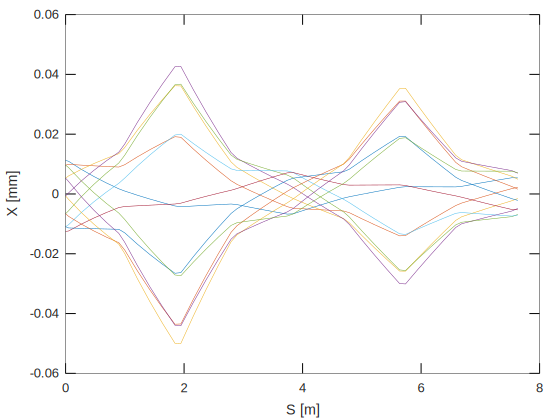

In [36]:
S = LINAC.get_transport_table('%S');
plot(S, T_X)
xlabel('S [m]')
ylabel('X [mm]')

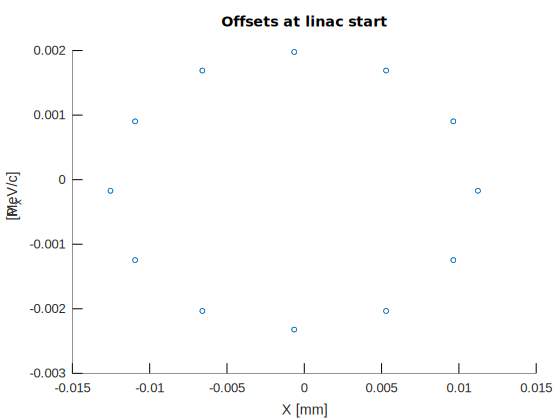

In [37]:
scatter(T_X(:,1), T_Px(:,1))
xlabel('X [mm]')
ylabel('P_x [MeV/c]')
title('Offsets at linac start')

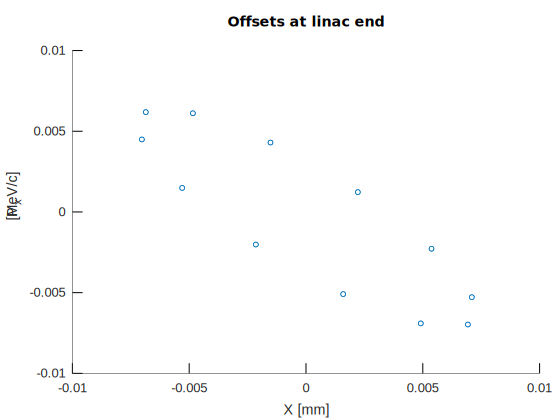

In [38]:
scatter(T_X(:,end), T_Px(:,end))
xlabel('X [mm]')
ylabel('P_x [MeV/c]')
title('Offsets at linac end')

In [39]:
Ai = polyarea (T_X(:,1), T_Px(:,1))

Ai = 7.6653e-05


In [40]:
Af = polyarea (T_X(:,end), T_Px(:,end))

Af = 7.6658e-05


In [41]:
Amplification_factor = sqrt(Af / Ai)

Amplification_factor = 1.0000


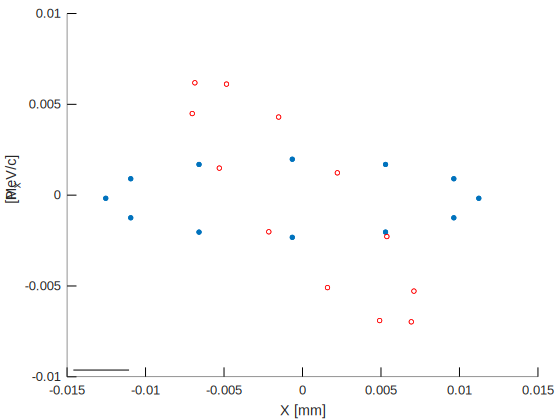

In [42]:
figure
hold on
scatter(T_X(:,1), T_Px(:,1), 'filled')
scatter(T_X(:,end), T_Px(:,end), 'r')
legend({ sprintf('initial area = %2.1f', Ai), sprintf('initial area = %2.1f', Af)});
legend('location', 'southwest', 'box', 'off');
xlabel('X [mm]')
ylabel('P_x [MeV/c]')